# Analysis of Plasma Spike-in Experiment (E.coli reference only)

In [1]:
import os
import glycoproteomics
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
#import matplotlib_inline
from pprint import pprint
#matplotlib_inline.backend_inline.set_matplotlib_formats("png")
figure_size = (8, 4)
dpi = 100



Set/toggle parameters for analysis

In [2]:
spectra_directory = "InputData" ### file directory to read from

### Pre-alignment normalisation
normalise_before_alignment = True ### should each sample be normalised before RT alignment (does not affect quantification)

### RT filtering 
filter_rt = True

max_rt = 23.5 
min_rt = 5.5

### Binning 
rt_x_bin_size = 0.025
mz_y_bin_size = 2.0

### Peak calling 
top_N_peaks = 5000

### Peak quantification ellipse
x_radius = rt_x_bin_size * 3.0
y_radius = mz_y_bin_size * 5.0


### Peak exclusion ellipse (within which the centre of another peak will not be called)
x_radius_exclude = x_radius * 3.0
y_radius_exclude = y_radius * 2.0

### Output filename
filename = "20220515_Spike_AllIons_EColiAligned_ExcludeRT3mz2.tsv"



Read in all spectra from folder:

In [3]:
spectra = glycoproteomics.io.read_spectra_directory(spectra_directory)
pprint(list(spectra.keys()))

['20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt']


Bin the spectra to make them easier to work with and merge

In [4]:
binned_spectra = {
    name: glycoproteomics.spectrum.bin(
        spectrum,
        rt_x_bin_size,
        mz_y_bin_size,
        np.mean)
    for name, spectrum in spectra.items()
}

del(spectra)

Filter by retention time

In [5]:
binned_filtered_spectra = {}
for name, spectrum in binned_spectra.items():
    binned_filtered_spectra[name] = glycoproteomics.spectrum.filter_rt(spectrum, min_rt, max_rt)

del(binned_spectra)

Set reference spectrum for RT alignment


In [6]:
#choose middle pooled QC
ref_name = "20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt"

print(ref_name)

20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt


Merge the spectra and plot the resulting merged spectrum.

['138.055', '186.076', '204.087', '274.092', '292.103', '366.14', '657.235']


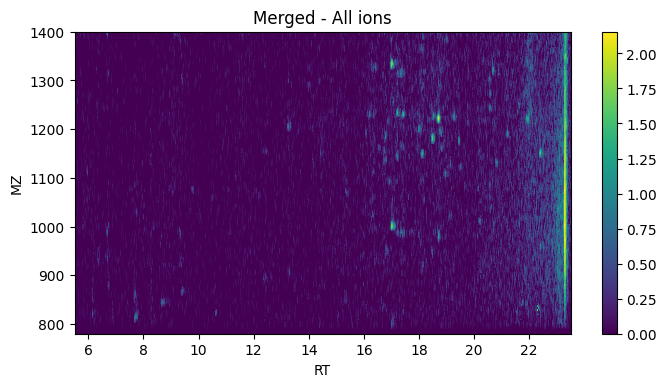

In [7]:
merged_spectrum = glycoproteomics.spectrum.combine(binned_filtered_spectra, np.sum)

ions = glycoproteomics.spectrum.list_ions(merged_spectrum)

print(ions)

merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(merged_spectrum, ions)
glycoproteomics.plotting.plot_ion_matrix(
    merged_ion_matrix,
    x_label,
    y_label,
    "Merged - All ions",
    figure_size,
    dpi
)
plt.show()

The individual spectra show that there is RT drifting at larger RT values. This can be corrected by using dynamic time warping (DTW). The implementation here can result in column duplication, which isn't great for integration, so should be used carefully. I recommend aligning the spectra prior to merging, to allow clean peaks to be called. Then use the DTW RT mappings to move the peaks for each peak prior to integration.

Peaks have to be aligned to a reference, which here is chosen to be the first sample.

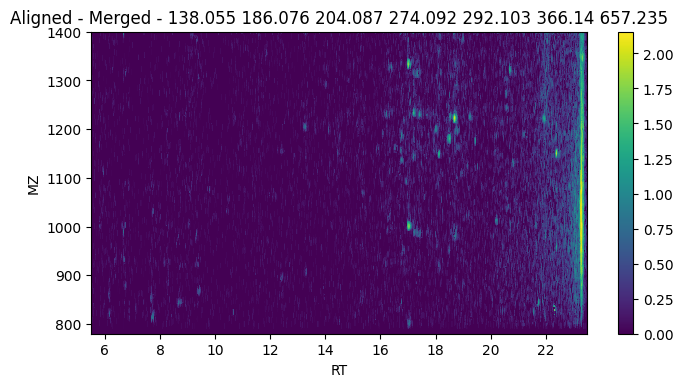

In [8]:
binned_aligned_filtered_sample_spectra = {}
rt_alignment_mappings = {}
for name, spectra in binned_filtered_spectra.items():
    aligned_spectra, rt_alignment = glycoproteomics.spectrum.align_rt(
        spectra,
        binned_filtered_spectra[ref_name], 
        1,
        normalise_before_alignment ### Set in the script parameters cell at top
    )
    binned_aligned_filtered_sample_spectra[name] = aligned_spectra
    rt_alignment_mappings[name] = rt_alignment

merged_spectrum = glycoproteomics.spectrum.combine(
    binned_aligned_filtered_sample_spectra,
    np.sum
)
merged_ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(
    merged_spectrum,
    ions
)
glycoproteomics.plotting.plot_ion_matrix(
    merged_ion_matrix,
    x_label,
    y_label,
    "Aligned - Merged - " + " ".join(ions),
    figure_size,
    dpi
)
plt.show()


Calling the top N peaks from the merged (aligned/filtered) spectrum.

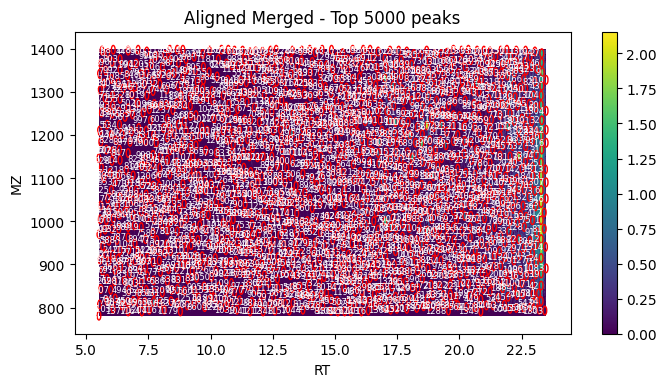

In [9]:
peaks = glycoproteomics.peaks.find(
    merged_ion_matrix,
    x_label,
    y_label,
    top_N_peaks,
    x_radius_exclude, ### set in parameters cell
    y_radius_exclude ### set in parameters cell
)

glycoproteomics.plotting.plot_ion_matrix_with_peaks(
    merged_ion_matrix,
    x_label,
    y_label,
    peaks,
    x_radius,
    y_radius,
    "Aligned Merged - Top {} peaks".format(top_N_peaks),
    figure_size,
    dpi
)
plt.show()

For each individual spectrum, shift the peak positions (using the RT alignments) and sum all bins within each peak ellipse to generate a value for each peak.

In [11]:
aligned_peak_value_dict = {}
for name, spectrum in binned_filtered_spectra.items():
    moved_peaks = glycoproteomics.peaks.rt_move(peaks, rt_alignment_mappings[name])
    peak_indicies = None

    for ion in ions:
        ion_matrix, x_label, y_label = glycoproteomics.spectrum.to_matrix(spectrum, [ion])
        if peak_indicies is None:
            # The for the first ion, calculate the peak indicies to be used
            peak_indicies = glycoproteomics.peaks.convert_peaks_to_indicies(
                x_label,
                y_label,
                moved_peaks,
                x_radius,
                y_radius,
            )

        # Plot the individual spectrum with the merged peaks
        #glycoproteomics.plotting.plot_ion_matrix_with_peaks(
        #    ion_matrix,
        #    x_label,
        #    y_label,
        #    moved_peaks,
        #    x_radius,
        #    y_radius,
        #    "{} - Ion = {} - Top {} merged peaks".format(name, ion, top_N_peaks),
        #    figure_size,
        #    dpi
        #)
        #plt.show()
        
        # Determine the sum of values within the peak ellipse for each peak
        peak_values = glycoproteomics.peaks.integrate(
            ion_matrix, peak_indicies, np.sum
        )
        aligned_peak_value_dict.setdefault(ion, {})[name] = peak_values
        # Print the top 5 peaks
        print(peak_values[:5])
        
        ### add some sort of status bar to the print function (n features / m samples * x ions)

[463.0738899999999, 34.3647785, 29.8524882, 2.7834203000000004, 14.00533]
[68.6707994, 16.851882, 3.492997, 3.1040316000000003, 8.21801]
[842.086273, 202.062068, 176.865512, 101.83593700000002, 138.98671999999996]
[373.471522, 248.7441696, 127.77707699999999, 97.878326, 230.79027200000002]
[148.1167, 85.403071, 55.26110799999999, 57.979906, 51.73081619999999]
[1106.3336700000002, 673.8527780000001, 336.45900869999997, 366.892004, 312.291252]
[417.79647, 348.225157, 149.17196900000002, 261.98821499999997, 160.59251500000002]


Save output to .tsv

In [12]:
with open(filename, "w") as out_f:
    out_f.write("\t".join(
        [
            "spectrum_name",
            "ion",
            "peak_num",
            "merged_rt",
            "merged_mz",
            "merged_height",
            "persistence",
            "aligned_rt",
            "aligned_mz",
            "value"
        ]) + "\n"
    )
    for ion, spectra_dict in aligned_peak_value_dict.items():
            print('-- {}'.format(ion))
            for name, peak_values in spectra_dict.items():
                print('---- {}'.format(name))
                moved_peaks = glycoproteomics.peaks.rt_move(peaks, rt_alignment_mappings[name])
                for peak_idx in range(len(peak_values)):
                    out_f.write("\t".join(
                        [
                            name,
                            str(ion),
                            str(peak_idx + 1),
                            str(peaks[peak_idx][0][0]),
                            str(peaks[peak_idx][0][1]),
                            str(peaks[peak_idx][1]),
                            str(peaks[peak_idx][2]),
                            str(moved_peaks[peak_idx][0][0]),
                            str(moved_peaks[peak_idx][0][1]),
                            str(aligned_peak_value_dict[ion][name][peak_idx])
                        ]) + "\n"
                    )

-- 138.055
---- 20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt
-- 186.076
---- 20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt
-- 204.087
---- 20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt
-- 274.092
---- 20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt
-- 292.103
---- 20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt
-- 366.14
---- 20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt
-- 657.235
---- 20210723_glyco_plasma_ecoli_spike_2ug_1.wiff.dia.extracted.txt


### Enjoy!